In [10]:
!pwd

/Users/ingn/projects/codex-paper/images


In [29]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import cv2

%load_ext autoreload
%autoreload 2
from edof_debug import calculate_focus_stack

import cpbd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
def gradient_sharpness(array):
    gy, gx = np.gradient(array)
    gnorm = np.sqrt(gx**2 + gy**2)
    sharpness = np.average(gnorm)
    return sharpness

def image2uint8(array):
    aout = array.copy()
    q = np.quantile(aout, 0.999)
    aout[aout>q] = q
    aout = aout/q
    return (255*aout).astype(np.uint8)

In [67]:
all_image_files

['TMA1_reg36_raw/Region 1--Stage00--Z00--C00.tif',
 'TMA1_reg36_raw/Region 1--Stage00--Z01--C00.tif',
 'TMA1_reg36_raw/Region 1--Stage00--Z02--C00.tif',
 'TMA1_reg36_raw/Region 1--Stage00--Z03--C00.tif',
 'TMA1_reg36_raw/Region 1--Stage00--Z04--C00.tif',
 'TMA1_reg36_raw/Region 1--Stage00--Z05--C00.tif',
 'TMA1_reg36_raw/Region 1--Stage01--Z00--C00.tif',
 'TMA1_reg36_raw/Region 1--Stage01--Z01--C00.tif',
 'TMA1_reg36_raw/Region 1--Stage01--Z02--C00.tif',
 'TMA1_reg36_raw/Region 1--Stage01--Z03--C00.tif',
 'TMA1_reg36_raw/Region 1--Stage01--Z04--C00.tif',
 'TMA1_reg36_raw/Region 1--Stage01--Z05--C00.tif',
 'TMA1_reg36_raw/Region 1--Stage02--Z00--C00.tif',
 'TMA1_reg36_raw/Region 1--Stage02--Z01--C00.tif',
 'TMA1_reg36_raw/Region 1--Stage02--Z02--C00.tif',
 'TMA1_reg36_raw/Region 1--Stage02--Z03--C00.tif',
 'TMA1_reg36_raw/Region 1--Stage02--Z04--C00.tif',
 'TMA1_reg36_raw/Region 1--Stage02--Z05--C00.tif',
 'TMA1_reg36_raw/Region 1--Stage03--Z00--C00.tif',
 'TMA1_reg36_raw/Region 1--Stag

In [101]:
import tqdm.auto as tqdm
all_image_files = !ls TMA1_reg36_raw/*.tif | grep C00
z_cpbd = []
stage_id = []
z_level = []
region = []

for r in tqdm.trange(37):
    for s in range(4):
        image_files = [f for f in all_image_files if f'Stage{s:02d}' in f]
        image_files = [f for f in image_files if f'Region {r+1}--' in f]
        print(f'Region {r+1}', f'Stage{s:02d}', len(image_files))

        image = []
        for f in image_files:
            img = cv2.imread(f, -1)
            img = img[512:1024, 512:1024]
            image.append(img.copy())
            
        image = np.dstack(image)

        edof, _ = calculate_focus_stack(image)

        for z in range(image.shape[-1]):
            array = image[:,:,z].copy()
            metric = cpbd.compute(image2uint8(array))
            z_cpbd.append(metric)
            stage_id.append(f'Stage{s:02d}')
            z_level.append(f'{z:02d}')
            region.append(f'region{r:02d}')

        metric = cpbd.compute(image2uint8(edof))
        z_cpbd.append(metric)
        stage_id.append(f'Stage{s:02d}')
        z_level.append('edof')
        region.append(f'region{r:02d}')

z_df = pd.DataFrame({'CPBD': z_cpbd, 'tile': stage_id, 'z':z_level, 'region': region})

  0%|          | 0/37 [00:00<?, ?it/s]

Region 1 Stage00 6
Region 1 Stage01 6
Region 1 Stage02 6
Region 1 Stage03 6
Region 2 Stage00 6
Region 2 Stage01 6
Region 2 Stage02 6
Region 2 Stage03 6
Region 3 Stage00 6
Region 3 Stage01 6
Region 3 Stage02 6
Region 3 Stage03 6
Region 4 Stage00 6
Region 4 Stage01 6
Region 4 Stage02 6
Region 4 Stage03 6
Region 5 Stage00 6
Region 5 Stage01 6
Region 5 Stage02 6
Region 5 Stage03 6
Region 6 Stage00 6
Region 6 Stage01 6
Region 6 Stage02 6
Region 6 Stage03 6
Region 7 Stage00 6
Region 7 Stage01 6
Region 7 Stage02 6
Region 7 Stage03 6
Region 8 Stage00 6
Region 8 Stage01 6
Region 8 Stage02 6
Region 8 Stage03 6
Region 9 Stage00 6
Region 9 Stage01 6
Region 9 Stage02 6
Region 9 Stage03 6
Region 10 Stage00 6
Region 10 Stage01 6
Region 10 Stage02 6
Region 10 Stage03 6
Region 11 Stage00 6
Region 11 Stage01 6
Region 11 Stage02 6
Region 11 Stage03 6
Region 12 Stage00 6
Region 12 Stage01 6
Region 12 Stage02 6
Region 12 Stage03 6
Region 13 Stage00 6
Region 13 Stage01 6
Region 13 Stage02 6
Region 13 Stage0

In [122]:
from matplotlib.colors import rgb2hex

cdict = {f'{i:02d}': rgb2hex(c) for i,c in enumerate(sns.color_palette('copper', 6))}
cdict['edof'] = 'r'

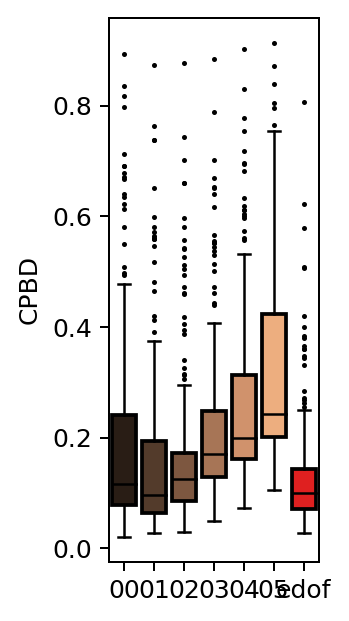

In [127]:
import seaborn as sns 
from statannot import add_stat_annotation

plt.figure(figsize=(1.5,4), dpi=180)
ax = plt.gca()
sns.boxplot(data=z_df, x='z', y='CPBD', ax=ax,
            #color='w',
            palette=cdict,
            fliersize=1,
            flierprops=dict(markeredgecolor='k', markerfacecolor='k', marker='o')
           )
ax.set_xlabel(None)
# ax.set_xticks([])
for i,box in enumerate(ax.artists):
    box.set_edgecolor('black')

    for j in range(i*6,i*6+6):
        line = ax.lines[j]
        line.set_color('k')
        line.set_linewidth(1)
        
# _ = add_stat_annotation(data=z_df, x='z', y='CPBD', ax=ax,
#                     box_pairs=[
#                         ['00', 'edof'],
#                         ['01', 'edof'],
#                         ['02', 'edof'],
#                         ['03', 'edof'],
#                         ['04', 'edof'],
#                         ['05', 'edof'],
#                     ],
#                     test='Mann-Whitney',
#                     text_format='simple',
#                     comparisons_correction=None,
#                     verbose=False
#                    )

plt.savefig('figures/edof/CPBD_cycle0_channel0.svg', bbox_inches='tight', transparent=True)

In [162]:
size = 256
c1 = 256
c2 = 256

min_raw_cpbd = []
edof_cpbd = []
diff_cpbd = []
stage = []
regions = []
c1s = []
c2s = []

for s in [0,1]:
    for r in np.arange(36):
        image_files = [f for f in all_image_files if f'Stage{s:02d}' in f]
        image_files = [f for f in image_files if f'Region {r+1}--' in f]


        for c1 in [256, 512, 1024]:
            for c2 in [256, 512, 1024]:
                image = []
                cpbd_vals = []
                print(f'Region {r+1}', f'Stage{s:02d}', len(image_files), f'C1:{c1} C2:{c2}')
                for i,f in enumerate(image_files):
                    img = cv2.imread(f, -1)
                    img_sub = img[c1:c1+size, c2:c2+size]

                    metric = cpbd.compute(image2uint8(img_sub))
                    cpbd_vals.append(metric)
                    image.append(img_sub.copy())

                image = np.dstack(image)

                edof, index_values = calculate_focus_stack(image)
                metric = cpbd.compute(image2uint8(edof))

                if metric < np.min(cpbd_vals):
                    min_raw_cpbd.append(np.min(cpbd_vals))
                    edof_cpbd.append(metric)
                    diff_cpbd.append( np.min(cpbd_vals) - metric )
                    stage.append(s)
                    regions.append(r)
                    c1s.append(c1)
                    c2s.append(c2)
            
cpbd_df = pd.DataFrame({'raw_CPBD': min_raw_cpbd, 'EDOF_CPBD': edof_cpbd, 'diff_CPBD': diff_cpbd,
                        'stage': stage, 'region': regions})

Region 1 Stage00 6
Region 2 Stage00 6
Region 3 Stage00 6
Region 4 Stage00 6
Region 5 Stage00 6
Region 6 Stage00 6
Region 7 Stage00 6
Region 8 Stage00 6
Region 9 Stage00 6
Region 10 Stage00 6
Region 11 Stage00 6
Region 12 Stage00 6
Region 13 Stage00 6
Region 14 Stage00 6
Region 15 Stage00 6
Region 16 Stage00 6
Region 17 Stage00 6
Region 18 Stage00 6
Region 19 Stage00 6
Region 20 Stage00 6
Region 21 Stage00 6
Region 22 Stage00 6
Region 23 Stage00 6
Region 24 Stage00 6
Region 25 Stage00 6
Region 26 Stage00 6
Region 27 Stage00 6
Region 28 Stage00 6
Region 29 Stage00 6
Region 30 Stage00 6
Region 31 Stage00 6
Region 32 Stage00 6
Region 33 Stage00 6
Region 34 Stage00 6
Region 35 Stage00 6
Region 36 Stage00 6
Region 1 Stage01 6
Region 2 Stage01 6
Region 3 Stage01 6
Region 4 Stage01 6
Region 5 Stage01 6
Region 6 Stage01 6
Region 7 Stage01 6
Region 8 Stage01 6
Region 9 Stage01 6
Region 10 Stage01 6
Region 11 Stage01 6
Region 12 Stage01 6
Region 13 Stage01 6
Region 14 Stage01 6
Region 15 Stage01 

In [165]:
cpbd_df = pd.DataFrame({'raw_CPBD': min_raw_cpbd, 'EDOF_CPBD': edof_cpbd, 'diff_CPBD': diff_cpbd,
                        'stage': stage, 'region': regions})
cpbd_df.sort_values('diff_CPBD', ascending=False)

,raw_CPBD,EDOF_CPBD,diff_CPBD,stage,region
237,0.735799,0.389101,0.346697,1,23
76,0.520352,0.237037,0.283315,0,23
170,0.655195,0.436326,0.218870,1,11
213,0.634748,0.437500,0.197248,1,20
130,0.560653,0.364198,0.196456,1,2
...,...,...,...,...,...
33,0.140431,0.139590,0.000841,0,11
150,0.053135,0.052353,0.000781,1,6
270,0.093916,0.093827,0.000089,1,31
273,0.035884,0.035800,0.000083,1,32


In [168]:
s = 1
r = 11

image_files = [f for f in all_image_files if f'Stage{s:02d}' in f]
image_files = [f for f in image_files if f'Region {r+1}--' in f]

print(f'Region {r+1}', f'Stage{s:02d}', len(image_files))

image = []
cpbd_vals = []
for i,f in enumerate(image_files):
    img = cv2.imread(f, -1)
    img = img[corner_1:corner_1+size, corner_2:corner_2+size]

    cv2.imwrite(f'figures/edof/raw_{i:02d}.png', image2uint8(img))
    image.append(img.copy())

image = np.dstack(image)

edof, index_values = calculate_focus_stack(image)
cv2.imwrite('figures/edof/edof.png', image2uint8(edof))


Region 12 Stage01 6


True

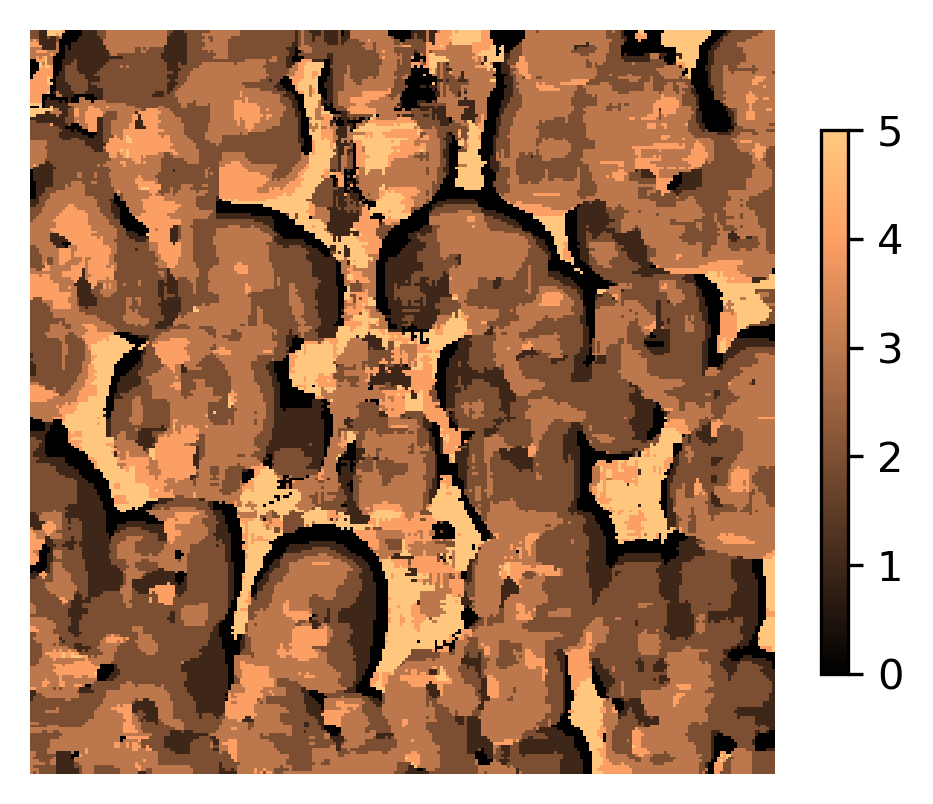

In [169]:
from matplotlib import rcParams
rcParams['svg.fonttype'] = 'none'
plt.figure(figsize=(4,4), dpi=300)
ax = plt.gca()
m = ax.matshow(index_values, cmap='copper')
plt.colorbar(m, ax=ax, shrink=0.6)
plt.axis('off')

plt.savefig('figures/edof/indices.svg', bbox_inches='tight', transparent=True)